# Chapter 3: Female mice with m = 1000 features

Just the enough elements for training the model

In [1]:
import time
import numpy as np
import pandas as pd
from scipy import stats   #ttest


# Import tensorFlow / Keras
import tensorflow as tf
from tensorflow import keras

In [2]:
# 1) Download the female mice control population

url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleControlsPopulation.csv"
df = pd.read_csv(url)
population = df.to_numpy().flatten()

# 2) Function:
def femaleMiceWeightSimulation(N = 12, 
                               m = 100, 
                               p0 = 0.90, 
                               delta = 3,  
                               seed = 42):
  '''
  Function to create the X image representation and Y response. 
  Additionally, list of pvalues, LBBF
  Input
  -----
  N = 12               # Sample size
  m = 100              # Number of test
  p0 = 0.90            # 10% of diets work, 90% don't
  delta = 3            # Effect size


  Output: Dictionary with the following elements
  ------
  X: matrix dimension mxm with the lbf quotients
  Y: Array with the real values of the null hypothesis (1) null is false, (0) otherwiese
  p_value: List of p-values
  LBBF: list of Lower bound byes factor
  ES: Vector with the apllied vector size.
  P0: Proportion null hypothesis is true
  '''
    
  m0 = np.int16(np.ceil(m*p0))  # Number of test where null hypothesis is true (s)
  m1 = np.int16(m-m0)           # Number of test where null hypothesis is false (saved like int)

  # Ground truth
  nullHypothesis = np.append(np.ones(m0, dtype=bool),np.zeros(m1, dtype=bool) )

  # Sample
  np.random.seed(seed)
  controls   = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
  treatments = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
  treatments[np.logical_not(nullHypothesis),] = treatments[np.logical_not(nullHypothesis),] + delta

  # Computing the pvalues: 
  p_values = np.array([result[1] for result in list(map(stats.ttest_ind, controls, treatments))])

  # Copy the vector of p-values and null hypothesis
  p_values_sorted = p_values.copy()
  H = nullHypothesis.copy()

  # Then, we order the vectors of p-values and null_hyporhesis
  o = np.argsort(p_values)
  p_values_sorted = p_values_sorted[o]
  H = H[o]
    
  # Response: Positive class: 1 Detect H0 false (H1 true)
  Y = np.logical_not(H).astype(int)

  # We compute the results under the following procedures:
   
  # 3) Bayesian approach (LBBF)
  lbf = np.where(p_values_sorted < (1/np.exp(1)), -np.exp(1)*p_values_sorted*np.log(p_values_sorted), 1) # Bayes Factor Lower Boun

  # To compute the quotient lbf[t]/lbf, we create a lambda function
  div_lbf = lambda t: lbf[t]/lbf

  # Then, the image is compute for each vector inptu
  image_lbf = np.array([div_lbf(xi) for xi in np.arange(0,m)]).T

  # We compute the maximum lbf quotient, in order to standarize the matrix in the range 0 and 1
  max_lbf = np.max(image_lbf)

  # Input of the ANNs - CNNs
  X = image_lbf/max_lbf
  # otuput of the function
  output_dict = {'X': X,  'Y': Y, 
                 'p_value': p_values_sorted,  'LBBF':  lbf,
                 'ES': delta, 'Prop_H0': p0}

  return output_dict

In [3]:
_m =  1000  # Number of test
_N = 12    # Sample Size

print('Number of test:', _m)
print('Sample Size:', _N)
print('----------------')

# Effect size
min_delta = 2   # Min Effect size
max_delta = 15  # Max effect size


vec_delta = np.arange(min_delta, max_delta, 0.1)
print(len(vec_delta))
print('Effect size:', vec_delta)
print('----------------')

# Proportion of (true) null hypothesis
vec_prop = np.array([0.9, 0.95, 0.99])
#vec_prop = np.arange(0.9, 1, 0.01)
print('No. proportions of H0:', len(vec_prop))
print('Proportion Null Hypothesis true:', vec_prop)

Number of test: 1000
Sample Size: 12
----------------
130
Effect size: [ 2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3
  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7
  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1
  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5
  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9
  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3
 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7
 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1
 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5
 14.6 14.7 14.8 14.9]
----------------
No. proportions of H0: 3
Proportion Null Hypothesis true: [0.9  0.95 0.99]


In [4]:
# We simulate 20 for each Effect size (delta) and 4 different null (true) hypothesis
_image_lbbf = [femaleMiceWeightSimulation(N = _N, m = _m, p0 = _prop, delta = _delta) for _delta in vec_delta for _prop in vec_prop]


In [7]:
# Active variables in the enviroment
%who_ls

['keras',
 'np',
 'pd',
 'population',
 'stats',
 'tf',
 'time',
 'url',
 'vec_delta',
 'vec_prop']

In [30]:
# Delete innecesary variables
#del df, femaleMiceWeightSimulation,max_delta,min_delta, pd,population,stats,vec_delta,vec_prop,url

In [8]:
# Number of simulations:
n_sim = len(_image_lbbf)

# Extracting the image as X
X = np.array([_image_lbbf[index]['X'] for index in range(0, n_sim)])
print('X shape:', X.shape)

# Extracting the response (Y)
Y = np.array([_image_lbbf[index]['Y'] for index in range(0, n_sim)])
print('Y shape:', Y.shape)

# Extracting the p-values ()
#p_values = np.array([_image_lbbf[index]['p_value'] for index in range(0, n_sim)])
#print('P-values shape:', p_values.shape)

X shape: (390, 1000, 1000)
Y shape: (390, 1000)


In [9]:
# Separtion train(validation)/test using permutation: train_test_split consumes a lot of memory
np.random.seed(42)
total_random_sample = np.random.permutation(n_sim)

## Train/test
n_test = np.int16(np.floor(n_sim*0.2))
n_train_full = n_sim - n_test

idx_train_full = total_random_sample[:n_train_full]
idx_test = total_random_sample[n_train_full:]

## Validation/test
n_val = np.int16(np.floor(n_train_full*0.1))
n_train = n_train_full - n_val

idx_train = total_random_sample[:n_train]
idx_valid = total_random_sample[(n_train_full-n_val):n_train_full]

print('Index: train, validation, test:')
print(n_train,n_val, n_test)


Index: train, validation, test:
281 31 78


In [10]:
X_train, X_valid, X_test = X[idx_train,:,:], X[idx_valid,:,:], X[idx_test,:,:]
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

y_train, y_valid, y_test = Y[idx_train,:], Y[idx_valid,:], Y[idx_test,:]

# For studying the proportions train/test
#y_train_full = Y[idx_train_full,:]
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(281, 1000, 1000)
(31, 1000, 1000)
(78, 1000, 1000)
(281, 1000)
(31, 1000)
(78, 1000)


In [12]:
%who_ls

['X_test',
 'X_train',
 'X_valid',
 'keras',
 'np',
 'pd',
 'population',
 'stats',
 'tf',
 'time',
 'url',
 'vec_delta',
 'vec_prop',
 'y_test',
 'y_train',
 'y_valid']

In [11]:
del X,Y,idx_test,idx_train,idx_train_full,idx_valid,n_sim,n_test,n_train,n_train_full,n_val,total_random_sample

In [13]:
# No. of channels = 1 (gray scale)

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

## Print dimensions for inputs
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('X_test shape: ', X_test.shape)
print('--------------------------')

# Refresh: Number of (null) hypothesis test
print('Total Null hypothesis:', _m)
print('--------------------------')

# Multilabel classification: Define the number of elements of input/output in the NN
# same as (_m)

INPUT_SHAPE  = [_m, _m, 1]
OUT_CLASSES = _m

# print
print('Input: Dimension image LBBF: ', INPUT_SHAPE)
print('Output: Number of labels', OUT_CLASSES)

X_train shape: (281, 1000, 1000, 1)
X_valid shape: (31, 1000, 1000, 1)
X_test shape:  (78, 1000, 1000, 1)
--------------------------
Total Null hypothesis: 1000
--------------------------
Input: Dimension image LBBF:  [1000, 1000, 1]
Output: Number of labels 1000


In [14]:
# Define a simple sequential model
def create_CNN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS,
                     SEED = 42):

  # 0)
  keras.backend.clear_session()

  # 1) Set seed
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  # 2) Sequential model
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 2, 
                        kernel_size = 3, 
                        padding = "same", 
                        activation = "relu",
                        kernel_initializer = INITIALIZER,
                        input_shape = INPUT_SHAPE),
    keras.layers.MaxPooling2D(pool_size=(2, 2), 
                              strides=(2,2), 
                              padding='same'),
    keras.layers.Conv2D(filters = 4, 
                        kernel_size = 3, 
                        padding = "same", 
                        activation = "relu",
                        kernel_initializer = INITIALIZER),
    keras.layers.MaxPooling2D(pool_size=(2, 2), 
                              strides=(2,2), 
                              padding='same'),
    keras.layers.Conv2D(filters = 8, 
                        kernel_size = 3, 
                        padding = "same", 
                        activation = "relu",
                        kernel_initializer = INITIALIZER),
    keras.layers.MaxPooling2D(pool_size=(2, 2), 
                              strides=(2,2), 
                              padding='same'),
    keras.layers.Conv2D(filters = 16, 
                        kernel_size = 3, 
                        padding = "same", 
                        activation = "relu",
                        kernel_initializer = INITIALIZER),
    keras.layers.MaxPooling2D(pool_size=(2, 2), 
                              strides=(2,2), 
                              padding='same'),
    keras.layers.Conv2D(filters = 32, 
                        kernel_size = 3, 
                        padding = "same", 
                        activation = "relu",
                        kernel_initializer = INITIALIZER),
    keras.layers.Conv2D(filters = 32, 
                        kernel_size = 3, 
                        padding = "same", 
                        activation = "relu",
                        kernel_initializer = INITIALIZER),
    keras.layers.MaxPooling2D(pool_size=(3, 3), 
                              strides=(2,2), 
                              padding='same'),
    keras.layers.Conv2D(filters = 32, 
                        kernel_size = 3, 
                        padding = "same", 
                        activation = "relu",
                        kernel_initializer = INITIALIZER),
    keras.layers.MaxPooling2D(pool_size=(3, 3), 
                              strides=(2,2), 
                              padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(NEURONS_1, activation="relu", kernel_initializer=INITIALIZER),
    keras.layers.Dense(NEURONS_2, activation="relu", kernel_initializer=INITIALIZER),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(OUT_CLASSES, activation="sigmoid")
  ])

  #2) compile method
  model.compile(loss      = LOSS_FN,
                optimizer = OPTIMIZER,
                metrics   = METRICS)
  
  return model

In [15]:
# 2) Hyperparameters:

## 2.1) Number of neurons by (hidden) layer
NEURONS_1 = 300   # of the total pixels
NEURONS_2 = 250   #  of the total pixels

## 2.2) Initial weight
INITIALIZER = keras.initializers.HeUniform()

# 3)  compilationHyperparameters
LOSS_FN   = keras.losses.binary_crossentropy
OPTIMIZER = keras.optimizers.Nadam()
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='AUROC'),
      keras.metrics.AUC(name='AUPRC', curve='PR'), # precision-recall curve
]

# Create the model instance
model_CNN = create_CNN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS)

# Print Model summary (model's architecture)
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 1000, 2)     20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 500, 500, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 500, 4)       76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 250, 250, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 8)       296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 16)      1

In [16]:
# Model Train

# 1) Hypeparameters
EPOCHS = 50

# Early_stopping (avoid overfitting)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_AUPRC', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# 2) fit method

start_time = time.time()

history_CNN = model_CNN.fit(X_train, 
                            y_train, 
                            epochs = EPOCHS,
                            validation_data = (X_valid, y_valid),
                            callbacks=[early_stopping],
                            verbose=0)
print('Elapsed time (seconds) = {:.3f}'.format(time.time() - start_time))

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Elapsed time (seconds) = 156.684


# Save/Load

In some cases, the trainig uses all the Available RAM, so we save the model at this point and then, we can load and evaluate the performance of the model

In [18]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [29]:
# Save:
model_CNN.save('my_model_MICE_CNN_m1000.h5') 

%cp /content/my_model_MICE_CNN_m1000.h5 /content/gdrive/My\ Drive

#from google.colab import files
#files.download("my_model_MICE_CNN_m1000.h5")

In [ ]:
# Load: Recreate the exact same model, including its weights and the optimizer
model_CNN = keras.models.load_model('/content/gdrive/MyDrive/my_model_MICE_CNN_m1000_150.h5')

# Show the model architecture
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 1000, 2)     20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 500, 500, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 500, 4)       76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 250, 250, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 8)       296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 16)      1

# Evaluation of the model

In [17]:
eval_train = model_CNN.evaluate(X_train, y_train, verbose=0)

# Print loss and metrics evaluation train set
print('Train loss = {:.3f}'.format(eval_train[0]))
print('-----------------------')
print('Train Accuracy  = {:.3f}'.format(eval_train[1]))
print('Train Precision = {:.3f}'.format(eval_train[2]))
print('Train Recall    = {:.3f}'.format(eval_train[3]))
print('Train AUROC     = {:.3f}'.format(eval_train[4]))
print('Train AUPRC     = {:.3f}'.format(eval_train[5]))

Train loss = 0.036
-----------------------
Train Accuracy  = 0.988
Train Precision = 0.933
Train Recall    = 0.826
Train AUROC     = 0.994
Train AUPRC     = 0.944


In [21]:
eval_test = model_CNN.evaluate(X_test, y_test, verbose = 0)

# Print loss and metrics evaluation test set
print('Test loss = {:.3f}'.format(eval_test[0]))
print('-----------------------')
print('Test Accuracy  = {:.3f}'.format(eval_test[1]))
print('Test Precision = {:.3f}'.format(eval_test[2]))
print('Test Recall    = {:.3f}'.format(eval_test[3]))
print('Test AUROC     = {:.3f}'.format(eval_test[4]))
print('Test AUPRC     = {:.3f}'.format(eval_test[5]))

Test loss = 0.039
-----------------------
Test Accuracy  = 0.989
Test Precision = 0.937
Test Recall    = 0.860
Test AUROC     = 0.986
Test AUPRC     = 0.941


In [22]:
y_score = model_CNN.predict(X_test)

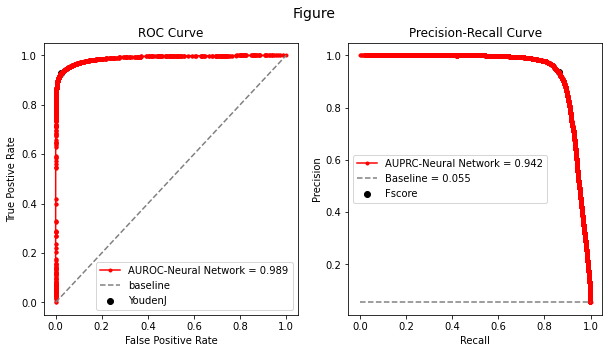

In [23]:
from sklearn.metrics import roc_curve,precision_recall_curve,auc
import matplotlib.pyplot as plt

def plot_ROC_PRC_score(y_test,
                       y_score,
                       plot = False,
                       title = 'Figure',
                       type_DL = 'Neural Network',
                       fig_save = None):
  # ROC components
  fpr_NN, tpr_NN, thresholds_ROC = roc_curve(y_test.ravel(), y_score.ravel())
  J = tpr_NN - fpr_NN
  ix_ROC = np.argmax(J)

  # PR components
  baseline_pr = np.sum(y_test.ravel())/len(y_test.ravel())
  prec_NN, recall_NN, thresholds_PR = precision_recall_curve(y_test.ravel(), y_score.ravel())

  fscore = (2*prec_NN*recall_NN)/(prec_NN + recall_NN)
  ix_PR = np.argmax(fscore)

  if plot is True:
    #Plot
    # Plot ROC and Precision-Recall
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax1.plot(fpr_NN, tpr_NN, marker='.', label='AUROC-'+type_DL+' = {:.3f}'.format(auc(fpr_NN,tpr_NN)), color = 'red')
    ax1.plot([0, 1], [0, 1], 'k--',label='baseline', color='grey')
    ax1.set_title('ROC Curve')
    ax1.set(xlabel='False Positive Rate', ylabel='True Postive Rate')
    ax1.scatter(fpr_NN[ix_ROC], tpr_NN[ix_ROC], marker='o', color='black', label='YoudenJ')
    ax1.legend()

    ax2.plot(recall_NN, prec_NN, marker='.', label='AUPRC-'+type_DL+' = {:.3f}'.format(auc(recall_NN,prec_NN)), color ='red')
    ax2.plot([0, 1], [baseline_pr, baseline_pr], linestyle='--', label='Baseline = {:.3f}'.format(baseline_pr), color = 'grey')
    ax2.scatter(recall_NN[ix_PR], prec_NN[ix_PR], marker='o', color='black', label='Fscore')
    ax2.set_title('Precision-Recall Curve')
    ax2.set(xlabel='Recall', ylabel='Precision')
    ax2.legend()

    fig.suptitle(title, fontsize=14)
    fig.show()
    if fig_save is not None:
      fig.savefig(fig_save)
  # End of if

  # output dict
  Youden_Stat = thresholds_ROC[ix_ROC]
  thresholds_PR_Stat = thresholds_PR[ix_PR]
  fscore = fscore[ix_PR]
  
  
  output_dict = {'thresholds_ROC': thresholds_ROC,
                 'fpr_NN': fpr_NN,
                 'Youden_Stat': Youden_Stat,
                 'thresholds_PR_Stat':thresholds_PR_Stat,
                 'fscore':fscore}
  return output_dict

# calculate ROC and Precision-Recall curves
stats_CNN = plot_ROC_PRC_score(y_test = y_test,
                           y_score = y_score,
                           plot = True)

# Functions

In [24]:
def Multiple_Significant_values(v_grid, 
                                            a_pvalues,
                                            a_nullHypothesis,
                                            n_m,
                                            n_sim):
  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  # Ravel the vectors of v_pvalues and v_nullHypothesis

  v_pvalues = a_pvalues.ravel()
  v_nullHypothesis = a_nullHypothesis.ravel()

  roc_values_HT = [[0,0]]
  prec_recall_HT = [[0,1]]
  counts_HT = [[0, 0, 0, np.sum(v_nullHypothesis), len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  
  for _alpha in v_grid:
    call = np.where(v_pvalues <= _alpha, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    R = fp + tp
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    #prec = tp/(tp + fp)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_HT.append([fpr, tpr])
    prec_recall_HT.append([tpr, prec])
    counts_HT.append([R, fp, tp, fn, tn, fnr])
    # End for

  #----------------------------------------------------
  # 2) Bonferroni correction
  roc_values_Bonf = [[0,0]]
  prec_recall_Bonf = [[0,1]]
  counts_Bonf = [[0, 0, 0, np.sum(v_nullHypothesis), len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  for _alpha in v_grid:
    Bonf_bound = _alpha/n_m
    call = np.where(v_pvalues <= Bonf_bound, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    R = fp + tp
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    #prec = tp/(tp + fp)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_Bonf.append([fpr, tpr])
    prec_recall_Bonf.append([tpr, prec])
    counts_Bonf.append([R, fp, tp, fn, tn, fnr])
    # End for

  #----------------------------------------------------
  # 3) Benjamini Hocheberg FDR
  
  roc_values_BH = [[0,0]]
  prec_recall_BH = [[0,1]]
  counts_BH = [[0,0,0,np.sum(v_nullHypothesis),len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  for _q in v_grid:
    BH_bound = np.arange(1,n_m+1)*(_q)/n_m
    BH_bound = np.tile(BH_bound,n_sim)
    call_BH_q = np.where(v_pvalues < BH_bound, False, True)
    code_call_BH_q = np.logical_not(call_BH_q).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call_BH_q).ravel()
    R = fp + tp
    fpr = fp/(fp + tn)
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_BH.append([fpr, tpr])
    prec_recall_BH.append([tpr, prec])
    counts_BH.append([R, fp, tp, fn, tn, fnr])
    # End for

  # Outout_dict
  output_dict = {'roc_values_HT': roc_values_HT, 'prec_recall_HT': prec_recall_HT, 'counts_HT' : counts_HT,
                 'roc_values_Bonf': roc_values_Bonf, 'prec_recall_Bonf': prec_recall_Bonf, 'counts_Bonf' : counts_Bonf,
                 'roc_values_BH': roc_values_BH, 'prec_recall_BH': prec_recall_BH, 'counts_BH' : counts_BH}

  return output_dict

In [25]:
# --------------------------------------------------------
# 5)

def DL_Significant_values(v_grid, a_test, a_score):

  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  y_fpr, _, thresholds = roc_curve(a_test.ravel(), a_score.ravel())
   
  roc_values_DL = [[0,0]]
  prec_recall_DL = [[0,1]]
  v_nullHypothesis = a_test.ravel()
  counts_DL = [[0, 0, 0, np.sum(v_nullHypothesis),len(v_nullHypothesis) - np.sum(v_nullHypothesis), 1]]
  for tt in v_grid:

    # Create copy of the thresholds and fpr objects
    max_thr_fpr = thresholds[len(y_fpr[y_fpr <= tt]) - 1]
    y_hat = np.where(a_score >= max_thr_fpr, 1,0)
    
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, y_hat.ravel()).ravel()
    R = fp + tp
    fpr = fp/(fp + tn)
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_DL.append([fpr, tpr])
    prec_recall_DL.append([tpr, prec])
    counts_DL.append([R, fp, tp, fn, tn, fnr])
    # End for

  # Outout_dict
  output_dict = {'roc_values_DL': roc_values_DL, 'prec_recall_DL': prec_recall_DL, 'counts_DL' : counts_DL}

  return output_dict

In [26]:
# 1)
def plot_performance(v_grid,
                     out_sig_grid,
                     baseline_pr,
                     title = 'Figure', 
                     DL = False, 
                     out_DL = None,
                     type_DL = 'Neural Network',
                     fig_save = None):

  ext_grid = np.append(0, v_grid)

  # HT Uncorrected
  rej_HT, fp_HT, tp_HT, fn_HT,_,_ = zip(*out_sig_grid['counts_HT'])
  fpr_HT, tpr_HT = zip(*out_sig_grid['roc_values_HT'])
  recall_HT, prec_HT = zip(*out_sig_grid['prec_recall_HT'])

  # Bonferroni correction
  rej_Bonf, fp_Bonf, tp_Bonf, fn_Bonf,_,_ = zip(*out_sig_grid['counts_Bonf'])
  fpr_Bonf, tpr_Bonf = zip(*out_sig_grid['roc_values_Bonf'])
  recall_Bonf, prec_Bonf = zip(*out_sig_grid['prec_recall_Bonf'])

  # BH
  rej_BH, fp_BH, tp_BH, fn_BH,_,_ = zip(*out_sig_grid['counts_BH'])
  fpr_BH, tpr_BH = zip(*out_sig_grid['roc_values_BH'])
  recall_BH, prec_BH = zip(*out_sig_grid['prec_recall_BH'])

  if out_DL is not None:
    # 3) DL results
    rej_DL, fp_DL, tp_DL, fn_DL,_,_ = zip(*out_DL['counts_DL'])
    fpr_DL, tpr_DL = zip(*out_DL['roc_values_DL'])
    recall_DL, prec_DL = zip(*out_DL['prec_recall_DL'])

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

  # Subplot Rejection
  ax1.plot(ext_grid,rej_HT,'-', color='darkviolet',label = 'Uncorrected')
  ax1.plot(ext_grid,rej_Bonf, '-', color='orange', label = 'Bonferroni')
  ax1.plot(ext_grid,rej_BH, '-', color='green' ,label = 'BH')
  if DL is True:
    ax1.plot(ext_grid,rej_DL, '-', linewidth = 2, color='red', label = type_DL)
  ax1.set_title('Total Rejections')
  ax1.set(xlabel='Significant values', ylabel = 'Rejections (R)')
  ax1.legend()

  # Subplot ROC
  ax2.plot(fpr_HT,tpr_HT,'-', color='darkviolet', label = 'AUROC-HTU = {:.3f}'.format(auc(fpr_HT,tpr_HT)))
  ax2.plot(fpr_Bonf,tpr_Bonf, '-',color='orange', label = 'AUROC-Bonf = {:.3f}'.format(auc(fpr_Bonf,tpr_Bonf)))
  ax2.plot(fpr_BH,tpr_BH, '-' , color='green' , label = 'AUROC-BH = {:.3f}'.format(auc(fpr_BH,tpr_BH)))
  if DL is True:
    ax2.plot(fpr_DL,tpr_DL,'-', linewidth = 2, color='red', label = 'AUROC-'+type_DL+' = {:.3f}'.format(auc(fpr_DL,tpr_DL)))
  ax2.plot(np.linspace(0, 1*np.max(fpr_HT), 100),
         np.linspace(0, 1*np.max(fpr_HT), 100),
         label='baseline',
         linestyle='--',
         color = 'grey')
  ax2.set_title('ROC Curve')
  ax2.set(xlabel='False positive rate (FPR)', ylabel='True positive rate (TPR)')
  ax2.set_ylim([0, 1.05])
  ax2.legend()

  # Subplot Precision-Recall
  ax3.plot(recall_HT,prec_HT,'-', color='darkviolet', label = 'AUPRC-HTU = {:.3f}'.format(auc(recall_HT,prec_HT)))
  ax3.plot(recall_Bonf,prec_Bonf, '-',color='orange', label = 'AUPRC-Bonf = {:.3f}'.format(auc(recall_Bonf,prec_Bonf)))
  ax3.plot(recall_BH,prec_BH, '-' , color='green' , label = 'AUPRC-BH = {:.3f}'.format(auc(recall_BH,prec_BH)))
  if DL is True:
    ax3.plot(recall_DL,prec_DL,'-', linewidth = 2 ,color='red', label = 'AUPRC-'+type_DL+' = {:.3f}'.format(auc(recall_DL,prec_DL)))
  
  ax3.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.3f}'.format(baseline_pr), color = 'grey')
  ax3.set_title('Precision-Recall Curve')
  ax3.set(xlabel='Recall', ylabel='Precision')
  ax3.set_ylim([0, 1.05])
  ax3.legend()

  fig.suptitle(title, fontsize=14)
  fig.show()
  if fig_save is not None:
    fig.savefig(fig_save)

# Particular evaluation

In [27]:
import pandas as pd
from scipy import stats   #ttest

alpha = 0.05         # Significance level
N = 12               # Sample size
m = 1000             # Number of test
p0 = 0.90            # 10% of diets work, 90% don't
m0 = np.int16(m*p0)  # Number of test where null hypothesis is true (saved like int)
m1 = np.int16(m-m0)  # Number of test where null hypothesis is false (saved like int)
delta = 3            # Average effect size

url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleControlsPopulation.csv"
df = pd.read_csv(url)
population = df.to_numpy().flatten()


# Ground truth
nullHypothesis = np.append(np.ones(m0, dtype=bool),np.zeros(m1, dtype=bool) )
# Monte Carlo Simulation. We sample individuals with dimensions 10.000 X 12
np.random.seed(42)
controls   = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
treatments = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
treatments[np.logical_not(nullHypothesis),] = treatments[np.logical_not(nullHypothesis),] + delta
p_values = np.array([result[1] for result in list(map(stats.ttest_ind, controls, treatments))])

asc_sort = np.argsort(p_values)

# Order the p-values and null hypothesis
p_values = p_values[asc_sort]
nullHypothesis = nullHypothesis[asc_sort]
code_nullHypothesis = np.logical_not(nullHypothesis).astype(int)

# We compute the BF lower bound. Print his shape and some of the values
lbf = np.where(p_values < (1/np.exp(1)), -np.exp(1)*p_values*np.log(p_values), 1) # Bayes Factor Lower Bound
print(lbf.shape)

# To compute the quotient lbf[t]/lbf, we create a lambda function
div_lbf = lambda t: lbf[t]/lbf

# Then, the image is compute for each vector input using a list comprehension
image_lbf = np.array([div_lbf(xi) for xi in np.arange(0,m)]).T

# We compute the maximum lbf quotient, in order to standarize the matrix in the 
# range 0 and 1
max_lbf = np.max(image_lbf)
X = image_lbf/max_lbf
print('Maximum quotient = {:.3f}'.format(max_lbf))

# Standandarization of the image in range 0 - 1
print('Max pixel value = {:.0f}'.format(np.max(X)))
print('Min pixel value = {:.0f}'.format(np.min(X)))

# Where is the maximum and the minimum
ind_max = np.unravel_index(np.argmax(image_lbf, axis=None), image_lbf.shape)
ind_min = np.unravel_index(np.argmin(image_lbf, axis=None), image_lbf.shape)
print('Max value (First Entry position):', ind_max)
print('Min value (First Entry position):',ind_min)

X_test = X.reshape(1,m,m,1)
y_score = model_CNN.predict(X_test)

(1000,)
Maximum quotient = 3287.276
Max pixel value = 1
Min pixel value = 0
Max value (First Entry position): (0, 434)
Min value (First Entry position): (434, 0)


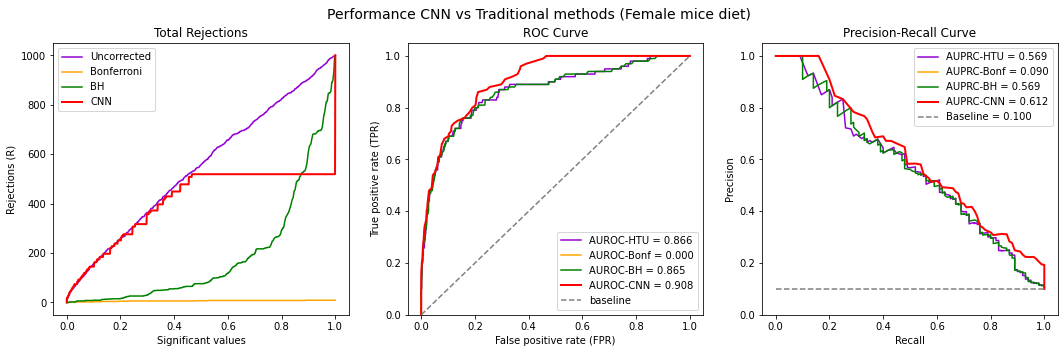

In [28]:
grid_significant =  np.arange(0, 1.001, 0.001)
#print('Significance levels :', grid_significant)
from sklearn.metrics import confusion_matrix

# Performance UHT, BFC and BHC
out_test_trad = Multiple_Significant_values(v_grid = grid_significant, 
                                            a_pvalues = p_values,
                                            a_nullHypothesis = code_nullHypothesis,
                                            n_m = 1000,
                                            n_sim = 1)

# Performance ANN for several significant values
out_test_DL_CNN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = code_nullHypothesis,     
                                      a_score = y_score)

# Plot function
baseline_pr = np.sum(code_nullHypothesis.ravel())/len(code_nullHypothesis.ravel())
plot_performance(v_grid = grid_significant,
                 out_sig_grid = out_test_trad,
                 baseline_pr = baseline_pr,
                 title = 'Performance CNN vs Traditional methods (Female mice diet)', 
                 DL = True, 
                 out_DL = out_test_DL_CNN,
                 type_DL = 'CNN')